<a href="https://colab.research.google.com/github/teruyuki-yamasaki/HelloGAN/blob/main/GAN_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN - Generative Adversarial Network

[今さら聞けないGAN（1）　基本構造の理解](https://qiita.com/triwave33/items/1890ccc71fab6cbca87e)

In [ ]:
from keras.datasets import mnist 
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D 
from keras.layers.advanced_activations import LeakyReLU 
from keras.layers import UpSampling2D, Conv2D 
from keras.models import Sequential, Model 
from keras import optimizers 
import numpy as np
import tensorflow as tf 

In [ ]:
class GAN():
    def __init__(self, shape=(28,28,1), z_dim=100, lr=2e-3, beta=0.5): 
        self.img_shape = shape
        self.img_rows, self.img_cols, self.img_channels = shape 
        self.z_dim = z_dim 

        #optimizer = optimizers.Adam(lr, beta)
        optimizer = tf.optimizers.Adam(lr, beta)
        
        self.generator = self.build_generator() 
        self.generator.compile(
            loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy']
        )

        self.discriminator = self.build_discriminator() 
        self.discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer)

        self.combined = self.build_combined1() 
        # self.combined = self.build_combined2() 
        self.combined.compile(loss = 'binary_crossentropy',optimizer = optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,) 
        model = Sequential() 

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape)))
        model.add(Activation('tanh')) 
        model.add(Reshape(self.img_shape)) 

        model.summary() 

        return model 

    def build_discriminator(self):
        img_shape = self.img_shape
        model = Sequential() 

        model.add(Flatten(input_shape=img_shape))  
        model.add(Dense(512)) 
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dense(256)) 
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dense(1))
        model.add(Activation('sigmoid')) 

        model.summary() 

        return model 

    
    def build_combined1(self):
        self.discriminator.trainable = False 
        model = Sequential([self.generator, self.discriminator])
        model.summary() 
        return model 
    
    def build_combined2(self):
        z = Input(input_shape=(self.z_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False 
        valid = self.discriminstor(img) 

        model = Model(inputs=z, outputs=valid) 
        model.summary() 

        return model 


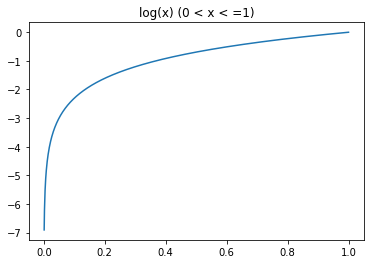

In [ ]:
import matplotlib.pyplot as plt 

x = np.linspace(1e-3, 1, 1000) 
y = np.log(x) 
plt.title('log(x) (0 < x < =1)')
plt.plot(x,y) 
plt.show()

## GANにおけるloss関数
$$
\mbox{min}_G \mbox{max}_D V(D,G) = \mathbb{E}_{\boldsymbol{x} \sim p_{data}(\boldsymbol{x})} \left[ \log D(\boldsymbol{x}) \right] + \mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})} \left[ \log (1 -  D(G(\boldsymbol{z}))) \right]
$$

- $\boldsymbol{x}$：確率密度関数の実現値としての画像
- $\boldsymbol{z} $：確率密度関数の実現値としての種
- $D$：Discriminator 
- $G$：Generator

### Dがうまく見破れるとき：
 - $\mathbb{E}_{\boldsymbol{x} \sim p_{data}(\boldsymbol{x})} \left[ D(\boldsymbol{x}) \right] \rightarrow 1$
 - $\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z} }(\boldsymbol{z})} \left[ D(G(\boldsymbol{z})) \right] \rightarrow 0$
 - $V \rightarrow 2$

### Gがうまく騙せるとき：
 - $\mathbb{E}_{\boldsymbol{x} \sim p_{data}(\boldsymbol{x})} \left[ D(\boldsymbol{x}) \right] \rightarrow 0$
 - $\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z} }(\boldsymbol{z})} \left[ D(G(\boldsymbol{z})) \right] \rightarrow 1$
 - $V \rightarrow - \infty$

In [ ]:
def save_imgs(model, epoch):
        title = 'epoch = {} '.format(epoch)
        #plt.title(title)
        print(title)

        # row,col
        r, c = 5, 5

        noise = np.random.normal(0, 1, (r * c, model.z_dim))
        gen_imgs = model.generator.predict(noise)

        # rescale [-1, 1] to [0, 1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1

        #fig.savefig("images/mnist_%d.png" % epoch)
        plt.show()
        plt.close()


def train(model, epochs, batch_size=128, save_interval=50):

    (X_train, y_train), (X_test, y_test) = mnist.load_data() 

    X_train = (X_train.astype(np.float32) - 127.5) / 127.5 
    X_train = np.expand_dims(X_train, axis=3) # (N, 28, 28) --> (N, 28, 28, 1) 
    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        # -------------------------------
        #   Dの訓練
        # -------------------------------
        idx = np.random.randint(0, X_train.shape[0], half_batch) 
        r_imgs = X_train[idx] 

        noise = np.random.normal(0,1, (half_batch, model.z_dim)) 
        g_imgs = model.generator.predict(noise) 

        # 本物データと偽物データは別々に学習
        d_loss_real = model.discriminator.train_on_batch(r_imgs, np.ones((half_batch,1))) 
        d_loss_fake = model.discriminator.train_on_batch(g_imgs, np.zeros((half_batch, 1))) 
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

        # -------------------------------
        #   Gの訓練
        # -------------------------------
        noise = np.random.normal(0,1,(batch_size, model.z_dim)) 
        valid_y = np.array([1] * batch_size)
        g_loss = model.combined.train_on_batch(noise, valid_y) # Dを騙すようにGを訓練
        
        #print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # 指定した間隔で生成画像を保存
        if epoch % save_interval == 0:
            save_imgs(model, epoch)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 256)               0         
                                                                 
 batch_normalization_9 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_22 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_10 (Bat  (None, 512)              2048      
 chNormalization)                                     

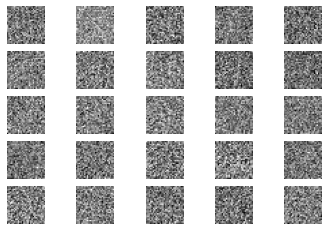

epoch = 1000 


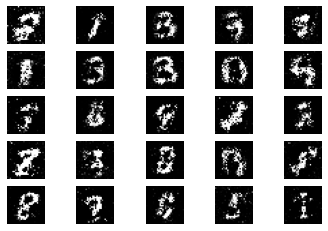

epoch = 2000 


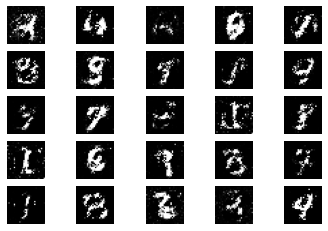

epoch = 3000 


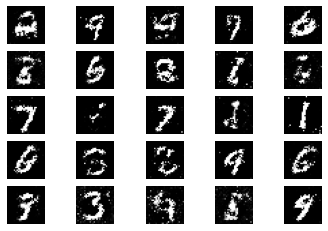

epoch = 4000 


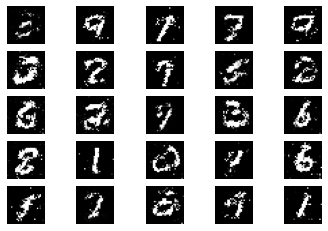

epoch = 5000 


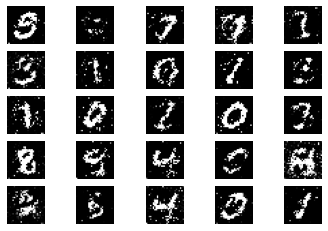

In [ ]:
gan = GAN() 
train(gan, epochs=5001, batch_size=32, save_interval=1000)

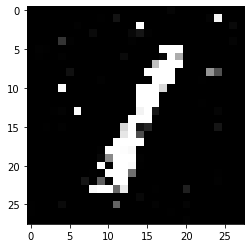

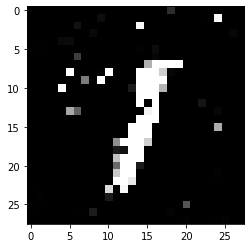

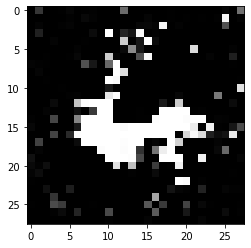

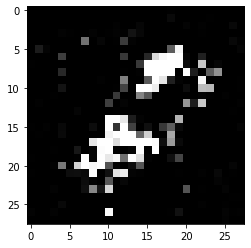

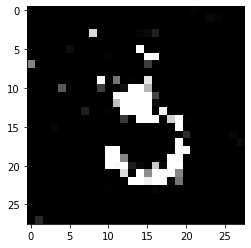

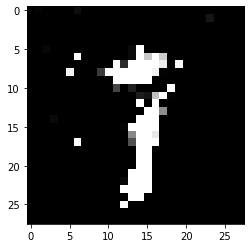

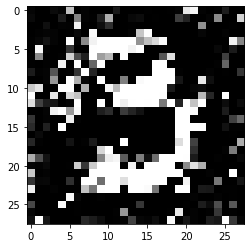

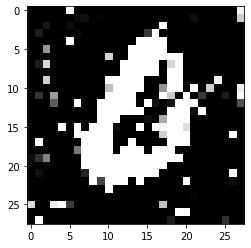

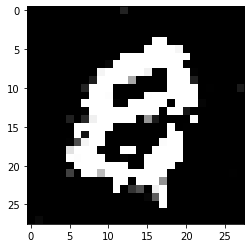

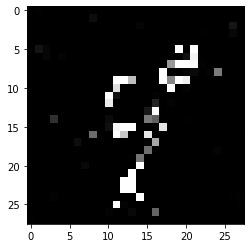

In [ ]:
for i in range(10):
    noise = np.random.normal(0,1,(1, gan.z_dim)) 
    g_img = gan.generator.predict(noise).reshape(28,28)
    plt.imshow(g_img, cmap='gray') 
    plt.show()

[今さら聞けないGAN （2）　DCGANによる画像生成](https://qiita.com/triwave33/items/35b4adc9f5b41c5e8141)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 5, 5, 128)         204928    
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 5, 5, 128)         0         
                                                                 
 flatten_6 (Flatten)         (None, 3200)              0         
                                                                 
 dense_36 (Dense)            (None, 256)               819456    
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 256)             

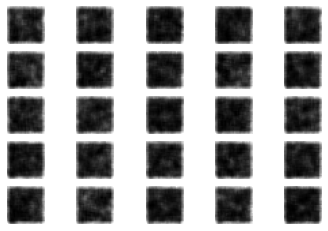

epoch = 1000 


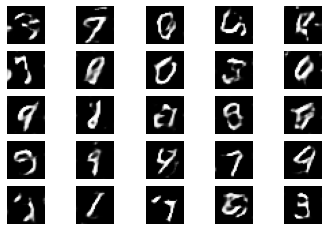

epoch = 2000 


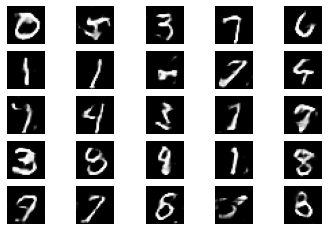

epoch = 3000 


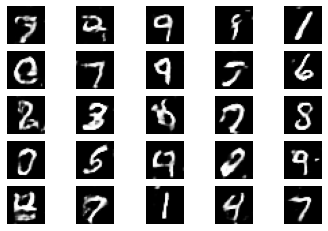

epoch = 4000 


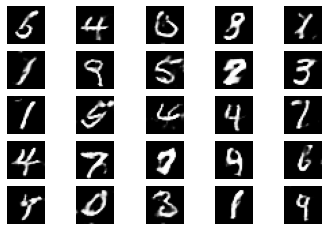

epoch = 5000 


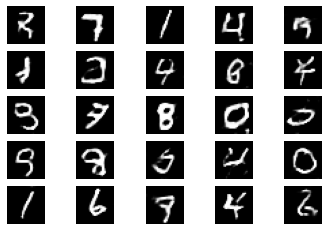

In [ ]:
from keras.layers import ZeroPadding2D 
from keras.layers.convolutional import UpSampling2D, Conv2D 

class DCGAN():
    def __init__(self, rows=28, cols=28, channels=1, z_dim=100):
        self.img_rows = rows 
        self.img_cols = cols 
        self.img_channels = channels  
        self.img_shape = (self.img_rows, self.img_cols, self.img_channels)

        self.z_dim = z_dim 

        optimizer = tf.optimizers.Adam(2e-3, 0.5) 

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy']
        )

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer) 

        self.combined = self.build_combined1() 
        # self.combined = self.build_combined2() 
        self.combined.compile(
            loss = 'binary_crossentropy',
            optimizer = optimizer 
        )

    def build_generator(self):
        noise_shape = (self.z_dim,) 
        model = Sequential() 
        model.add(Dense(1024, input_shape=noise_shape)) 
        model.add(BatchNormalization())
        model.add(Activation('relu')) 
        model.add(Dense(128*7*7)) 
        model.add(BatchNormalization())
        model.add(Activation('relu')) 
        model.add(Reshape((7,7,128), input_shape=(128*7*7,))) 
        model.add(UpSampling2D((2,2))) 
        model.add(Conv2D(64,(5,5),padding='same')) 
        model.add(BatchNormalization()) 
        model.add(Activation('relu')) 
        model.add(UpSampling2D((2,2)))
        model.add(Conv2D(1,(5,5), padding='same')) 
        model.add(Activation('tanh')) 
        model.summary() 
        return model 
        
    def build_discriminator(self):
        model = Sequential() 
        model.add(Conv2D(64,(5,5), strides=(2,2), padding='same', input_shape=self.img_shape)) 
        model.add(LeakyReLU(0.2)) 
        model.add(Conv2D(128,(5,5),strides=(2,2))) 
        model.add(LeakyReLU(0.2))
        model.add(Flatten()) 
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dropout(0.5))
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        model.summary() 

        return model 
    
    def build_combined1(self):
        self.discriminator.trainable = False 
        model = Sequential([self.generator, self.discriminator])
        #model.summary() 
        return model 
    
    def build_combined2(self):
        z = Input(input_shape=(self.z_dim,)) 
        g_img = self.generator(z) 
        self.discriminator.trainable = False 
        valid = self.discriminator(g_img)

        model = Model(inputs=z, outputs=valid) 
        model.summary() 

        return model 
    
def train(model, epochs=int(3e4), batch_size=100, save_interval=int(2.5e3)):

    (X_train, _), (_, _) = mnist.load_data()  
    X_train = np.expand_dims(X_train, axis=3)
    half_batch = batch_size // 2 

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        r_imgs = (X_train[idx] - 127.5) / 127.5 # [0,255] --> [-1,1] 

        z = np.random.normal(0, 1, (half_batch, model.z_dim))  
        g_imgs = model.generator(z) 

        d_loss_real = model.discriminator.train_on_batch(r_imgs, np.ones((half_batch,1)))
        d_loss_fake = model.discriminator.train_on_batch(g_imgs, np.zeros((half_batch,1))) 
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

        z = np.random.normal(0, 1, (half_batch, model.z_dim)) 
        g_loss = model.combined.train_on_batch(z, np.ones((half_batch,1)))

        if epoch % save_interval == 0:
            save_imgs(model, epoch)

dcgan = DCGAN() 
train(dcgan, epochs=5001, batch_size=32, save_interval=1000)

In [ ]:
def show_digits(model):
    for i in range(10):
        noise = np.random.normal(0,1,(1, model.z_dim)) 
        g_img = model.generator.predict(noise).reshape(28,28)
        plt.imshow(g_img, cmap='gray') 
        plt.show()

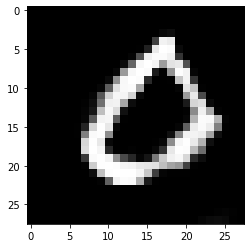

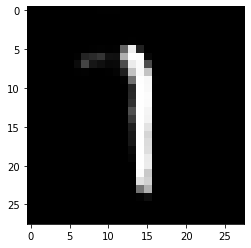

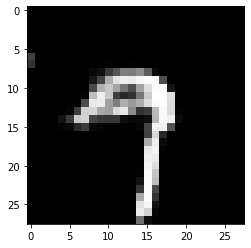

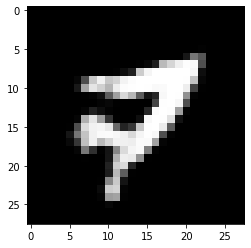

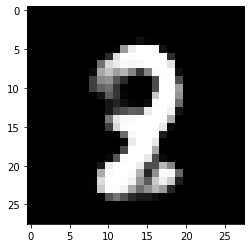

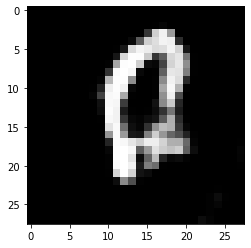

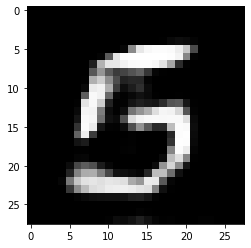

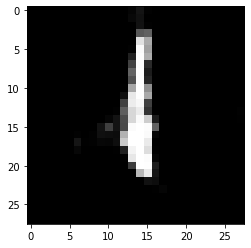

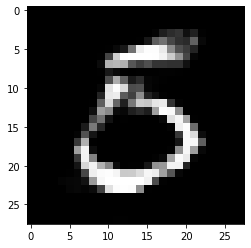

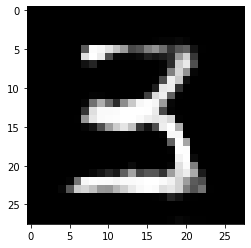

In [ ]:
show_digits(dcgan)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 
%cd /content/gdrive/MyDrive/Colab Notebooks/GAN/
%ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/GAN
cnn_model.h5  cnn_model.txt  cnn_weight.h5  GAN_intro.ipynb


In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model

#from keras.optimizers import Adam
#from tensorflow.optimizers import Adam
import tensorflow as tf 

import matplotlib.pyplot as plt

import sys

import numpy as np

class DCGAN():
    
    def __init__(self):
        self.path = "./images"

        # datasize for mnist 
        self.img_rows = 28 
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        self.z_dim = 5
        
        ########## settings for image saving ###########
        # for image saving
        self.row = 5
        self.col = 5
        self.row2 = 1 # for latent space
        self.col2 = 10# for latent space
        
        # as a noise "seed" for creating images from the same value
        self.noise_fix1 = np.random.normal(0, 1, (self.row * self.col, self.z_dim)) 
        # for moving latent variable (z) from fix2 to fix3
        self.noise_fix2 = np.random.normal(0, 1, (1, self.z_dim))
        self.noise_fix3 = np.random.normal(0, 1, (1, self.z_dim))

        ###############################################

        self.g_loss_array = np.array([])
        self.d_loss_array = np.array([])
        self.d_accuracy_array = np.array([])
        self.d_predict_true_num_array = np.array([])
        self.c_predict_class_list = []

        discriminator_optimizer = tf.optimizers.Adam(lr=1e-5, beta_1=0.1)
        combined_optimizer = tf.optimizers.Adam(lr=2e-4, beta_1=0.5)

        # discriminator model
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss='binary_crossentropy', 
            optimizer=discriminator_optimizer,
            metrics=['accuracy'])

        # Generator model
        self.generator = self.build_generator()

        self.combined = self.build_combined1()
        #self.combined = self.build_combined2()
        self.combined.compile(loss='binary_crossentropy', optimizer=combined_optimizer)

        # Classifier model
        self.classifier = self.build_classifier()

    def build_generator(self):

        noise_shape = (self.z_dim,)
        model = Sequential()
        model.add(Dense(1024, input_shape=noise_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dense(128*7*7))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Reshape((7,7,128), input_shape=(128*7*7,)))
        model.add(UpSampling2D((2,2)))
        model.add(Conv2D(64,(5,5),padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(UpSampling2D((2,2)))
        model.add(Conv2D(1,(5,5),padding='same'))
        model.add(Activation('tanh'))
        model.summary()
        return model

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()
        model.add(Conv2D(64,(5,5), strides=(2,2),\
                  padding='same', input_shape=img_shape))
        model.add(LeakyReLU(0.2))
        model.add(Conv2D(128,(5,5), strides=(2,2)))
        model.add(LeakyReLU(0.2))
        model.add(Flatten())
        model.add(Dense(256))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.5))
        model.add(Dense(1))
        model.add(Activation('sigmoid'))   
        return model
    
    def build_combined1(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        return model

    def build_combined2(self):
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False
        valid = self.discriminator(img)
        model = Model(z, valid)
        model.summary()
        return model
    
    # load extra model to classify the images created by generator
    def build_classifier(self):
        #cnn_model = "https://github.com/triwave33/GAN/blob/master/GAN/dcgan/cnn_model.h5"
        #cnn_weight = "https://github.com/triwave33/GAN/blob/master/GAN/dcgan/cnn_weight.h5"
        cnn_model = 'cnn_model.h5' 
        cnn_weight = 'cnn_weight.h5' # TypeError: __init__() missing 2 required positional arguments: 'filters' and 'kernel_size'
        model = load_model(cnn_model)
        model.load_weights(cnn_weight)
        return model

    def train(self, epochs, batch_size=128, save_interval=50):

        # load mnist data
        (X_train, _), (_, _) = mnist.load_data()

        # normalization
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        num_batches = int(X_train.shape[0] / half_batch)
        print('Number of batches:', num_batches)
                                
        self.g_loss_array = np.zeros(epochs)
        self.d_loss_array = np.zeros(epochs)
        self.d_accuracy_array = np.zeros(epochs)
        self.d_predict_true_num_array = np.zeros(epochs)

        for epoch in range(epochs):
            for iteration in range(num_batches):

                # ---------------------
                #  learn Discriminator
                # ---------------------

                # generate images (half batch size) from generato
                noise = np.random.normal(0, 1, (half_batch, self.z_dim))
                gen_imgs = self.generator.predict(noise)


                # pickup images (half batch size) from dataset
                idx = np.random.randint(0, X_train.shape[0], half_batch)
                imgs = X_train[idx]

                # learn discriminator
                d_loss_real = self.discriminator.train_on_batch(
                                    imgs, np.ones((half_batch, 1)))
                d_loss_fake = self.discriminator.train_on_batch(
                                    gen_imgs, np.zeros((half_batch, 1)))
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # predict (half: fake images, half: real images)
                d_predict = self.discriminator.predict_classes(
                                np.concatenate([gen_imgs,imgs]), verbose=0)
                d_predict = np.sum(d_predict)

                # label prediction by classifier
                c_predict = self.classifier.predict_classes(
                                np.concatenate([gen_imgs,imgs]), verbose=0)


                # ---------------------
                #  learn Generator
                # ---------------------

                noise = np.random.normal(0, 1, (batch_size, self.z_dim))
                # label must be set to 1 for generator learning
                valid_y = np.array([1] * batch_size)

                # Train the generator
                g_loss = self.combined.train_on_batch(noise, valid_y)

                # progress
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

                self.g_loss_array[epoch] = g_loss
                self.d_loss_array[epoch] = d_loss[0]
                self.d_accuracy_array[epoch] = 100*d_loss[1]
                self.d_predict_true_num_array[epoch] = d_predict
                self.c_predict_class_list.append(c_predict)

            if epoch % save_interval == 0:
                
                # save images from random seed
                self.save_imgs(self.row, self.col, epoch, '', noise)
                # save images from fixed seed
                self.save_imgs(self.row, self.col, epoch, 'fromFixedValue', self.noise_fix1)
                # save transition images between two latent variables
                total_images = self.row*self.col
                noise_trans = np.zeros((total_images, self.z_dim))
                for i in range(total_images):
                    t = (i*1.)/((total_images-1)*1.)
                    noise_trans[i,:] = t * self.noise_fix2 + (1-t) * self.noise_fix3
                self.save_imgs(self.row2, self.col2, epoch, 'trans', noise_trans)

                # discriminate images generated from Generator (10000 samples)
                noise = np.random.normal(0, 1, (10000, self.z_dim))
                class_res = self.classifier.predict_classes(self.generator.predict(noise), verbose=0)
                # plot histgram
                plt.hist(class_res)
                plt.savefig(self.path + "mnist_hist_%d.png" % epoch)
                plt.ylim(0,2000)
                plt.close()


                # plot learning result
                fig, ax = plt.subplots(4,1, figsize=(8.27,11.69))
                ax[0].plot(self.g_loss_array[:epoch])
                ax[0].set_title("g_loss")
                ax[1].plot(self.d_loss_array[:epoch])
                ax[1].set_title("d_loss")
                ax[2].plot(self.d_accuracy_array[:epoch])
                ax[2].set_title("d_accuracy")
                ax[3].plot(self.d_predict_true_num_array[:epoch])
                ax[3].set_title("d_predict_true_num_array")
                fig.suptitle("epoch: %5d" % epoch)
                fig.savefig(self.path + "training_%d.png" % epoch)
                plt.close()

        # save weights
        self.generator.save_weights(self.path + "generator_%s.h5" % epoch)
        self.discriminator.save_weights(self.path + "discriminator_%s.h5" % epoch)


            

    def save_imgs(self, row, col, epoch, filename, noise):
    
        gen_imgs = self.generator.predict(noise)
    
        # rescall generated images
        gen_imgs = 0.5 * gen_imgs + 0.5
    
    
        fig, axs = plt.subplots(row, col)
        cnt = 0
        if row == 1:
            for j in range(col):
                axs[j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[j].axis('off')
                cnt += 1
        else:
            for i in range(row):
                for j in range(col):
                    axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                    axs[i,j].axis('off')
                    cnt += 1

        fig.suptitle("epoch: %5d" % epoch)
        fig.savefig(self.path + "mnist_%s_%d.png" % (filename, epoch))
        plt.close()
    
gan = DCGAN()
gan.train(epochs=5001, batch_size=32, save_interval=1000)


Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 1024)              6144      
                                                                 
 batch_normalization_39 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 activation_54 (Activation)  (None, 1024)              0         
                                                                 
 dense_67 (Dense)            (None, 6272)              6428800   
                                                                 
 batch_normalization_40 (Bat  (None, 6272)             25088     


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 chNormalization)                                                
                                                                 
 activation_55 (Activation)  (None, 6272)              0         
                                                                 
 reshape_13 (Reshape)        (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_18 (UpSamplin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_41 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                                
                                                                 
 activation_56 (Activation)  (None, 14, 14, 64)        0         
          

TypeError: ignored

[今さら聞けないGAN（4） WGAN](https://qiita.com/triwave33/items/5c95db572b0e4d0df4f0)
Wasserstein GAN

#### the GAN's objective
$$
\mbox{min}_G \mbox{max}_D V(D,G) = \mathbb{E}_{\boldsymbol{x} \sim p_{data}(\boldsymbol{x})} \left[ \log D(\boldsymbol{x}) \right] + \mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})} \left[ \log (1 -  D(G(\boldsymbol{z}))) \right]
$$

#### the Jensen-Shannon divergence
$$
C(G) = - \log(4) + 2 \times JSD(p_{data} || p_g) 
$$

#### the Wasserstein disntance
$$
W(\mathbb{P}_r, \mathbb{P}_\theta) = \max_{w \in \mathcal{W}} \mathbb{E}_{x \sim \mathbb{P}_r} [f_w(x)] - \mathbb{E}_{z \sim p(z)}[f_w (g_\theta(z))]
$$

#### the WGAN's objective 
$$
L = \mathbb{E}_{\tilde{x} \sim \mathbb{P}_g} [D(\tilde{x})] - \mathbb{E}_{x \sim \mathbb{P}_r}[D(x)]
$$

the WGAN-gp (gradient penalty)'s objective 
$$
L = \underbrace{\mathbb{E}_{\tilde{x} \sim \mathbb{P}_g}[D(\tilde{x})] - \mathbb{E}_{x \sim \mathbb{P}_r}[D(x)]}_{\mbox{original critic loss}} + \underbrace{\lambda \mathbb{E}_{\hat{x} \sim \mathbb{P}_\hat{x}}\left[ ( \| \nabla_\hat{x} D(\hat{x}) \| _2 - 1 )^2 \right]}_{\mbox{gradient penalty}}
$$

[今さら聞けないGAN (5) WGAN-gpの実装](https://qiita.com/triwave33/items/72c7fceea2c6e48c8c07)

### 損失関数の定義

1. モデルの定義
2. 損失関数の定義
3. optimizerのインスタンス化
4. 入力、出力、optimizer(インスタンス化済)を引数とする関数化

In [ ]:
def build_discriminator_with_own_loss(self):
    img_shape = (self.img_rows, self.img_cols, self.channels) 

    z = Input(shape=(self.z_dim,)) 
    f_img = self.generator(z) 

    r_img = Input(shape=(img_shape)) 
    e_input = K.placeholder(shape=(None, 1, 1, 1)) 
    a_img = Input(shape=(img_shape), tensor=e_input*r_img + (1-e_input)*f_img) 

    f_out = self.discriminator(f_img)
    r_out = self.discriminator(r_img) 
    a_out = self.discrimnator(a_img) 

    loss_real = K.mean(r_out) 
    loss_fake = K.mean(f_out) 

    grad_mixed = K.gradients(a_out, [a_img])[0] # grad = K.gradients(model.output, model.input)
    norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1,2,3])) 
    grad_penalty = K.mean(K.square(norm_grad_mixed - 1)) 

    loss = loss_fake - loss_real + GRADIENT_PENALTY_WEIGHT * grad_penalty

    training_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9)\
                                        .get_updates(self.discriminator.tranable_weights, [], loss)
    
    # function(inputs, outputs, updates=None) 
    # inputs: プレースホルダーテンソルのリスト．
    # outputs: 出力のテンソルのリスト．
    # updates: 更新する命令のリスト．
    d_train = K.function([z, r_img, e_input], 
                                    [loss_real, loss_fake],
                                    training_updates) 
    
    return d_train 

In [ ]:
class WGAN():
    def __init__(self, rows=28, cols=28, channels=1, z_dim=100): 
        self.img_rows = rows 
        self.img_cols = cols 
        self.img_channels = channels 
        self.img_shape = (rows, cols, channels) 

        self.z_dim = z_dim 
        
        discriminator_optimizer = tf.optimizers.Adam(lr=1e-5, beta_1=0.1)
        combined_optimizer = tf.optimizers.Adam(lr=2e-4, beta_1=0.5)

        # discriminator model
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss='binary_crossentropy', 
            optimizer=discriminator_optimizer,
            metrics=['accuracy'])

        # Generator model
        self.generator = self.build_generator()

        self.combined = self.build_combined1()
        #self.combined = self.build_combined2()
        self.combined.compile(loss='binary_crossentropy', optimizer=combined_optimizer)
    
    def build_generator(self):

        noise_shape = (self.z_dim,)
        model = Sequential()
        model.add(Dense(1024, input_shape=noise_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dense(128*7*7))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Reshape((7,7,128), input_shape=(128*7*7,)))
        model.add(UpSampling2D((2,2)))
        model.add(Conv2D(64,(5,5),padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(UpSampling2D((2,2)))
        model.add(Conv2D(1,(5,5),padding='same'))
        model.add(Activation('tanh'))
        model.summary()
        return model

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()
        model.add(Conv2D(64,(5,5), strides=(2,2),\
                  padding='same', input_shape=img_shape))
        model.add(LeakyReLU(0.2))
        model.add(Conv2D(128,(5,5), strides=(2,2)))
        model.add(LeakyReLU(0.2))
        model.add(Flatten())
        model.add(Dense(256))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.5))
        model.add(Dense(1))
        model.add(Activation('sigmoid'))   
        return model
    
    def build_combined1(self):
        self.discriminator.trainable = False 
        model = Sequential([self.generator, self.discriminator])
        return model 
    
    def build_combined2(self):
        z = Input(input_shape=(self.z_dim,)) 
        f_img = self.generator(z) 
        self.discriminator.trainable=False 
        valid = self.discriminator(f_img) 
        model = Model(inputs=z, outputs=valid) 
        model.summary() 
        return model 

    def train(self, epochs, batch_size, save_interval):
        (X_train, _), (_, _) = mnist.load_data() 

        X_train = (X_train.astype(np.float32) - 127.5) / 127.5 
        X_train = np.expand_dims(X_train, axis=3) 

        half_batch = batch_size // 2 
        num_batches = X_train.shape[0] // half_batch 

        for epoch in range(epochs):
            for num_batch in range(num_batches):
                idx = np.random.randint(0, X_train.shape[0], half_batch) 
                r_imgs = X_train[idx]

                seeds = np.random.normal(0, 1, (half_batch, self.z_dim)) 
                f_imgs = self.generator(seeds) 

                d_loss_real = self.discrimination.train_on_batch(r_imgs, np.ones(half_batch))
                d_loss_fake = self.discrimination.train_on_batch(f_imgs, np.zeros(half_batch)) 
                d_loss = 0.5 * (d_loss_real + d_loss_fake) 

                seeds = np.random.normal(0, 1, (half_batch, self.z_dim)) 
                f_imgs = self.generator(seeds) 
                g_loss = self.generator.train_on_batch(f_imgs, np.ones(half_batch)) 